In [ ]:
from itertools import product
from pathlib import Path

import ee
import geemap
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr

# Data Loading and Preprocessing

In [2]:
PROJECT_PATH = Path(".")

DATA_PATH = PROJECT_PATH / "data"
DATA_RAW_PATH = DATA_PATH / "01_raw"

CHLOROPHYLL_DATA_PATH = (
    DATA_RAW_PATH / "chl_cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D.nc"
)

CHLOROPHYLL_DATA_PATH

PosixPath('data/01_raw/chl_cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D.nc')

We open the dataset. For convenience, we will change the names of the "longitude" and "latitude" columns to "lon" and "lat" respectively.

In [3]:
ds = xr.open_dataset(CHLOROPHYLL_DATA_PATH, engine="netcdf4")
ds = ds.rename({"longitude": "lon", "latitude": "lat"})

lat_min, lat_max = float(ds.lat.min()), float(ds.lat.max())
lon_min, lon_max = float(ds.lon.min()), float(ds.lon.max())
boundaries = (lon_min, lat_min, lon_max, lat_max)
centroid = ((lat_min + lat_max) / 2, (lon_min + lon_max) / 2)

print(ds)

<xarray.Dataset> Size: 635MB
Dimensions:  (time: 9842, lat: 168, lon: 96)
Coordinates:
  * lat      (lat) float32 672B -27.98 -27.94 -27.9 ... -21.1 -21.06 -21.02
  * lon      (lon) float32 384B -72.98 -72.94 -72.9 ... -69.1 -69.06 -69.02
  * time     (time) datetime64[ns] 79kB 1997-09-04 1997-09-05 ... 2024-08-14
Data variables:
    CHL      (time, lat, lon) float32 635MB ...
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    ...                              ...
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-20T15:24:55Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my

We start with a preliminary visualization of the data in your region.

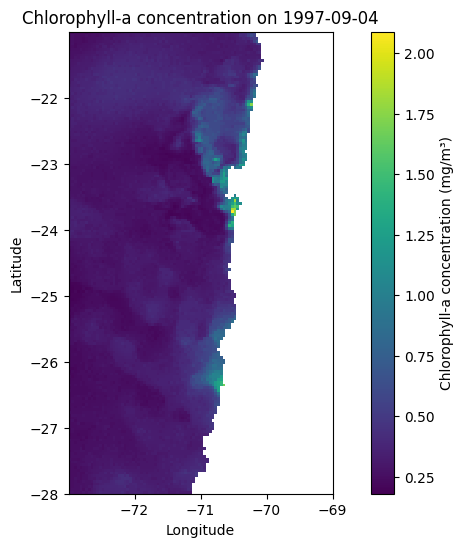

In [4]:
def plot_chlorophyll(ds, time_index, fig=None, ax=None, title=None, colorbar=True):

    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    lat = ds.lat.data
    lon = ds.lon.data
    chl = ds.CHL.data

    chl_has_na = np.isnan(chl).any()

    pcolormesh_kwargs = dict(shading="auto")
    if colorbar:
        # Add colormap if colorbar is True
        pcolormesh_kwargs["cmap"] = plt.cm.viridis

        # Set color limits if chl has no NaN values
        if not chl_has_na:
            chl_nonzero = chl[chl > 0]
            pcolormesh_kwargs["vmin"] = chl_nonzero.min()

    mesh = ax.pcolormesh(lon, lat, chl[time_index, :, :], **pcolormesh_kwargs)

    if colorbar:
        colorbar_kwargs = dict(ax=ax, label="Chlorophyll-a concentration (mg/m³)")

        # Set color limits for colorbar if chl has no NaN values
        if not chl_has_na:
            colorbar_kwargs["extend"] = "min"
            cbar = fig.colorbar(mesh, **colorbar_kwargs)
            cbar.cmap.set_under("gray")

        # Else, use default colorbar (if colorbar is True)
        else:
            fig.colorbar(mesh, **colorbar_kwargs)

    title = (
        title
        or f"Chlorophyll-a concentration on {str(ds.time[time_index].values)[:10]}"
    )

    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    ax.set_aspect("equal", adjustable="box")

    return fig, ax


plot_chlorophyll(ds, 0)
plt.show()

We can observe that at first, there is a large amount of missing data in a certain region. Let's check with Google Earth Engine how that region looks like.


In [ ]:
ee.Authenticate()
ee.Initialize()

region = ee.Geometry.Rectangle(boundaries)


def mask_clouds(image):
    # Select the QA60 band and create a cloud mask
    qa = image.select("QA60")
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    # Apply the cloud mask to the image
    return image.updateMask(mask).divide(10000)


# Select the Sentinel-2 image collection
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(region)
    .filterDate("2021-01-01", "2021-12-31")
    .map(mask_clouds)
)

vis_params = dict(bands=["B4", "B3", "B2"], min=0, max=0.3)

Map = geemap.Map(center=centroid, zoom=6)

Map.addLayer(collection.mosaic().clip(region), vis_params, "Sentinel-2 Copernicus")
Map.addLayer(region, {}, "Region of Interest")
Map.addLayerControl()

Map

Map(center=[-24.50000286102295, -70.99999618530273], controls=(WidgetControl(options=['position', 'transparent…

We can see that indeed the region that has missing values in the time series is the one that corresponds to the coast, at least the region that is systematically missing. Now let's review some images over the days to see if there is any missing data in between.

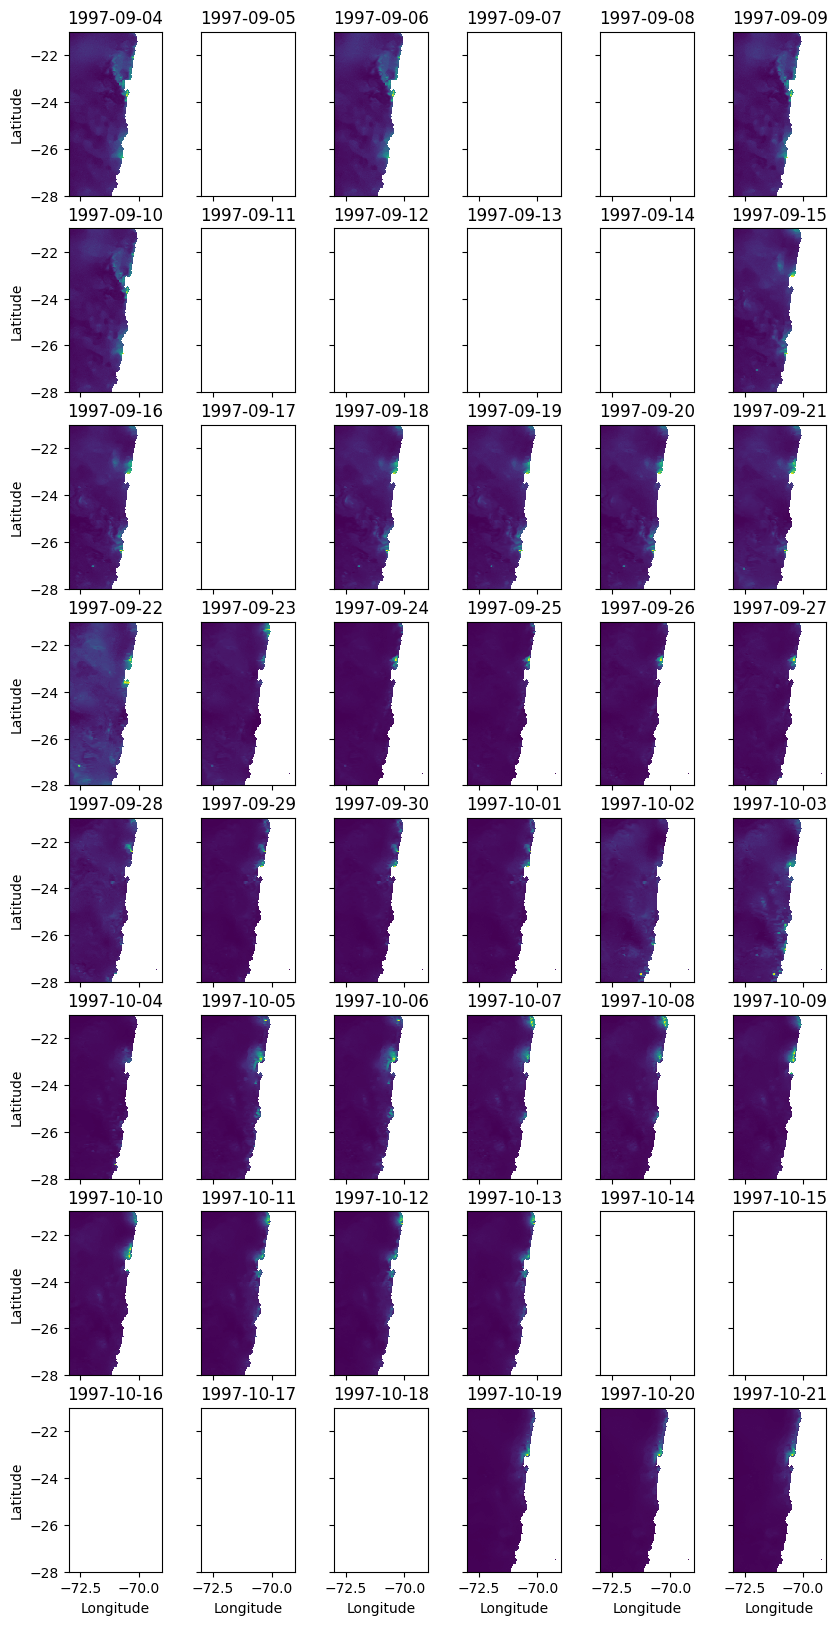

In [6]:
def plot_chlorophyll_grid(ds, n_row=8, n_col=6):

    fig, axs = plt.subplots(n_row, n_col, figsize=(10, 20))

    for i, j in product(range(n_row), range(n_col)):
        time_index = i * n_col + j
        plot_chlorophyll(
            ds,
            time_index,
            fig,
            axs[i, j],
            colorbar=False,
            title=f"{str(ds.time[time_index].values)[:10]}",
        )

        if j != 0:
            axs[i, j].set_ylabel("")
            axs[i, j].set_yticklabels([])

        if i != n_row - 1:
            axs[i, j].set_xlabel("")
            axs[i, j].set_xticklabels([])


plot_chlorophyll_grid(ds, n_row=8, n_col=6)
plt.show()

Indeed, there are times when there is no data. Let's choose some coordinate inside and check how the missing data is distributed over time.

In [7]:
chl_da = ds["CHL"].sel(lat=-24, lon=-72, method="nearest")
chl_np = chl_da.values

In [8]:
# Let's check the number of NaN values in the array
(
    int(np.isnan(chl_np).sum()),
    chl_np.size,
    float(np.isnan(chl_np).sum() / chl_np.size * 100),
)

(24, 9842, 0.24385287543182277)

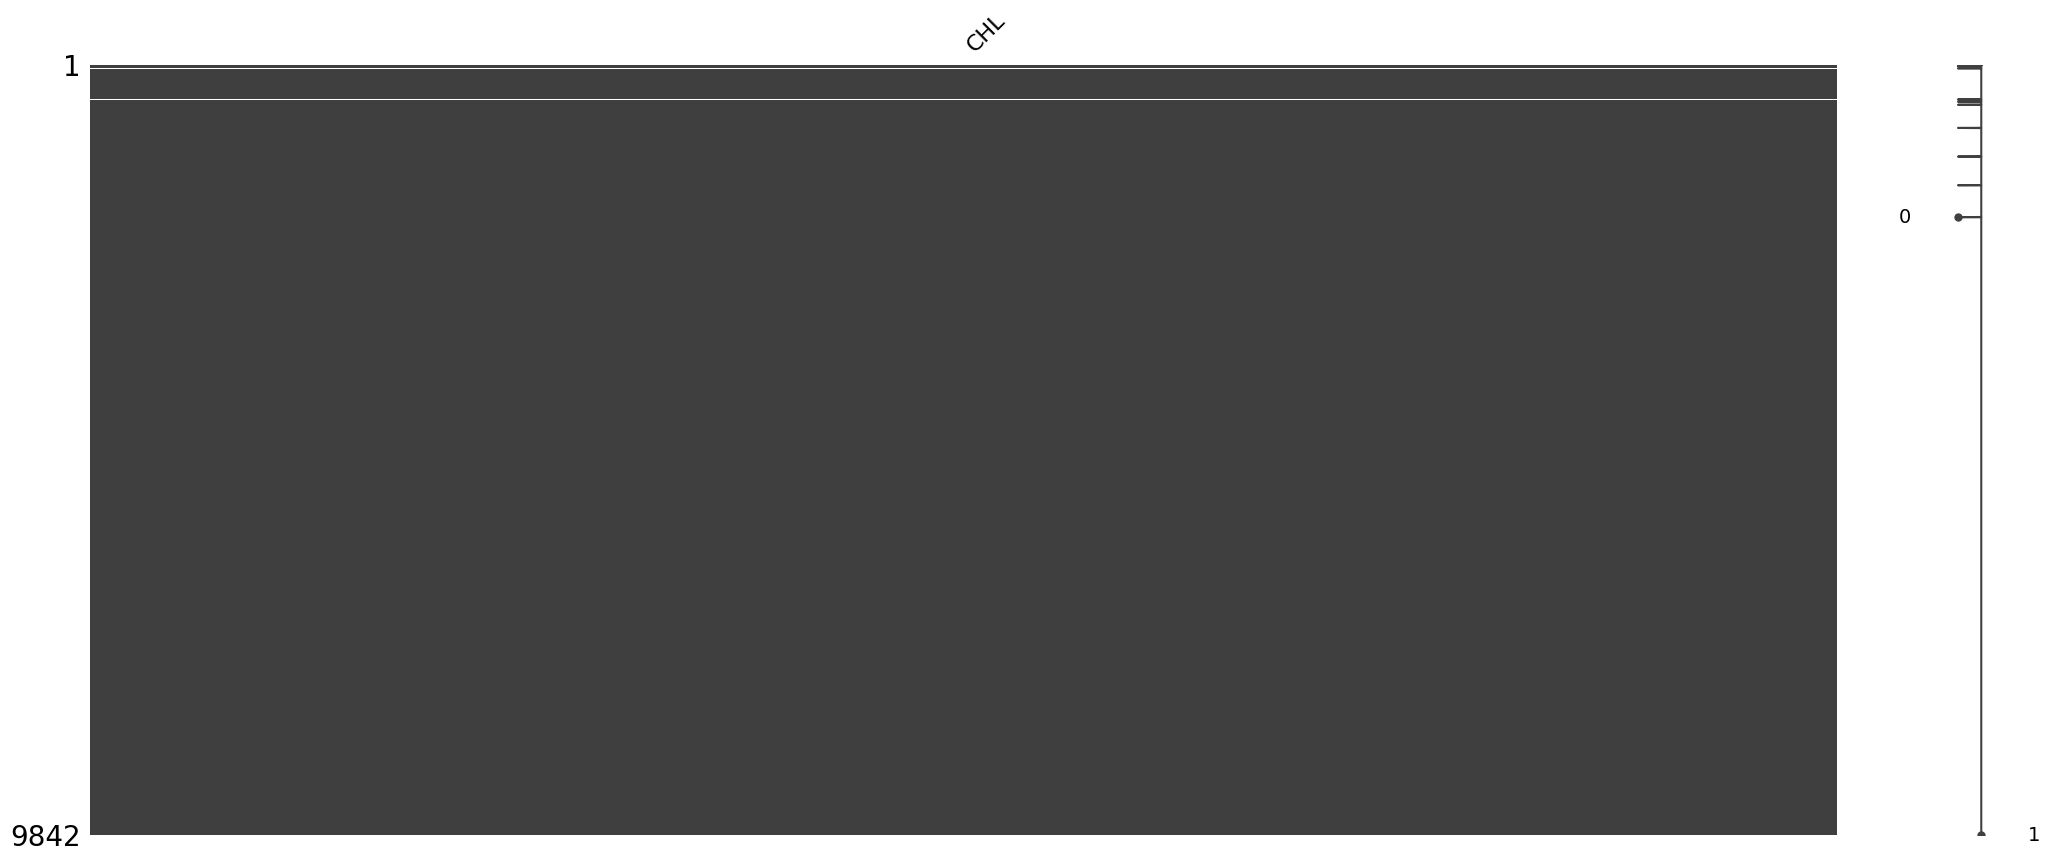

In [9]:
df = pd.DataFrame({"CHL": chl_np})

msno.matrix(df)
plt.show()

We note that the missing data are mainly at the beginning. Let's zoom in.

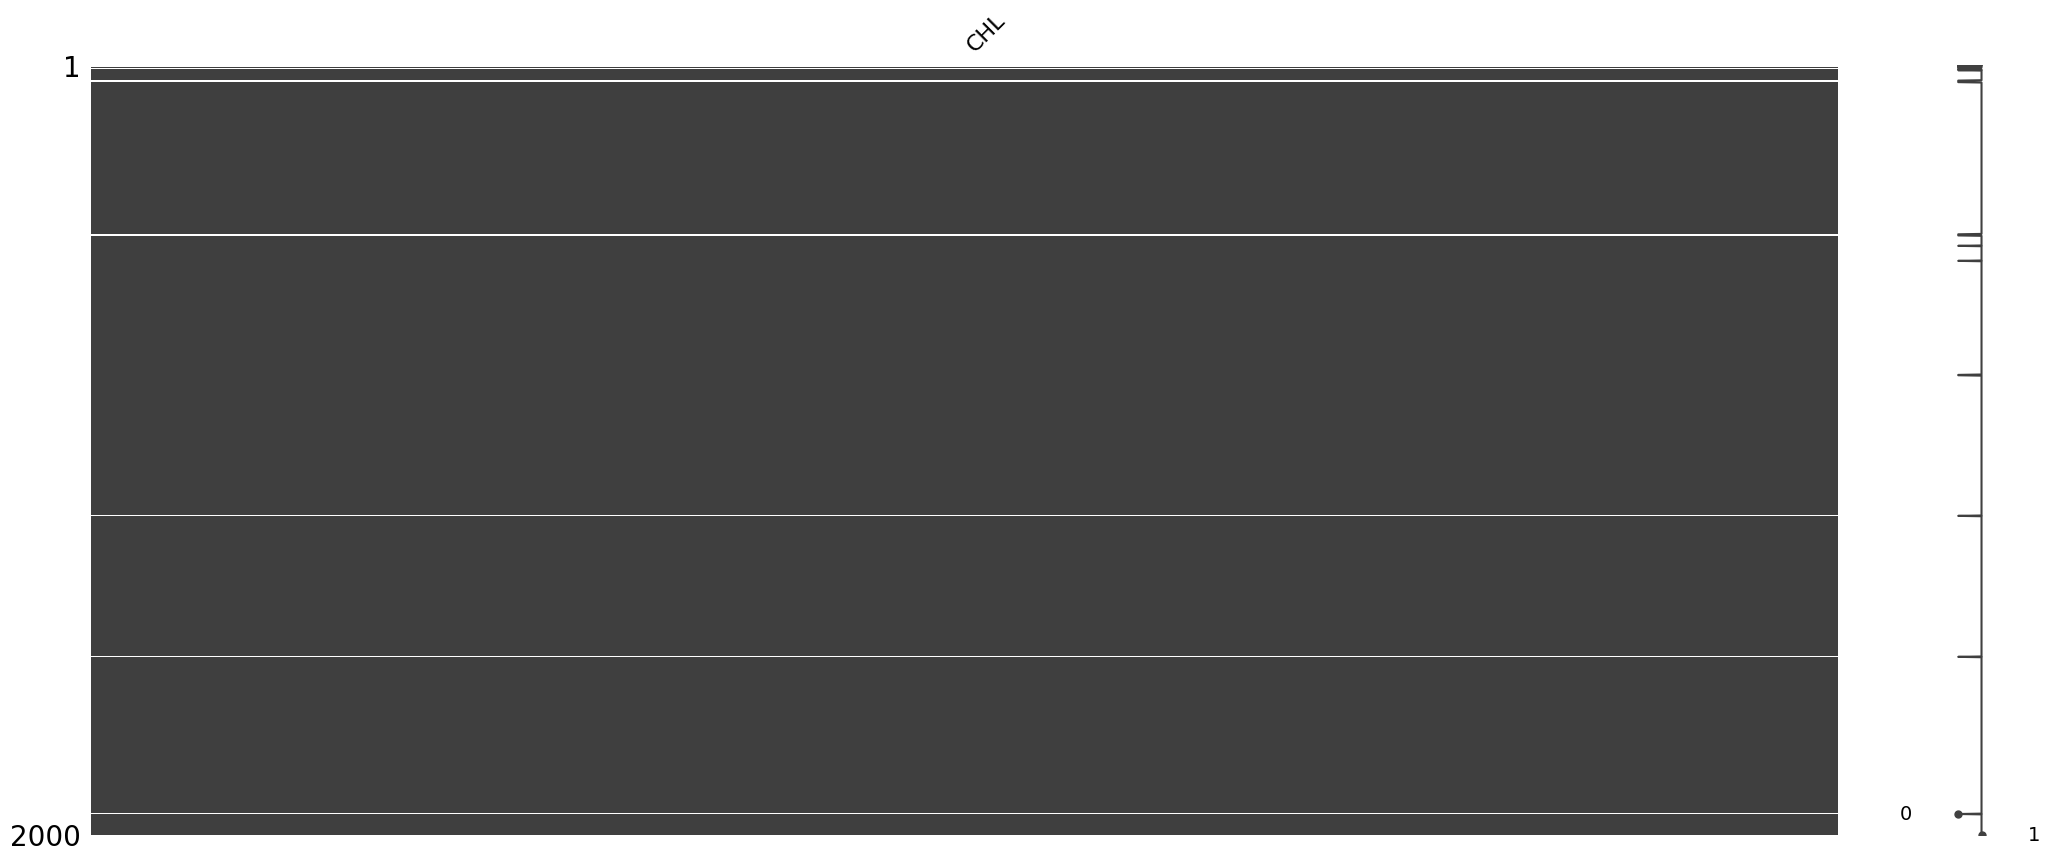

In [10]:
msno.matrix(df[:2000])
plt.show()

We can observe that throughout the time series, there are 24 occasions in which there is no data. This may be due to the presence of clouds at the time of image acquisition. In this case, since there are so few missing values, we can interpolate the values. In the sake of time and simplicity, we will use linear interpolation. If we find that this affects the result, we can switch to a more robust interpolation, such as spline or linear RBF, although sacrificing more computational time for such a small amount of data.

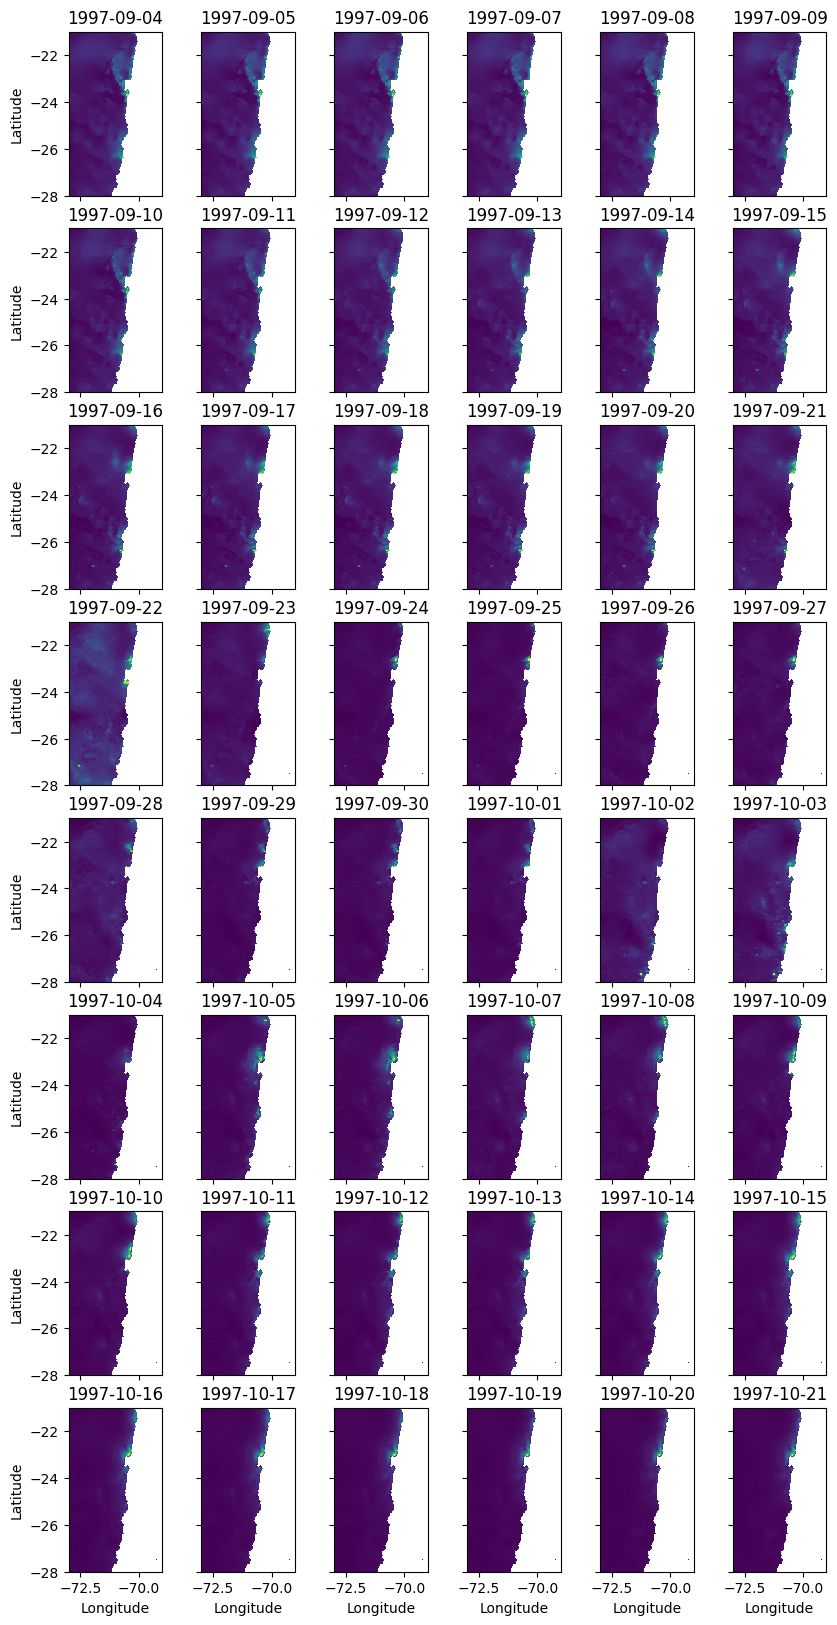

In [11]:
# interpolate nan
ds = ds.interpolate_na(dim="time", method="linear")

plot_chlorophyll_grid(ds, n_row=8, n_col=6)
plt.show()

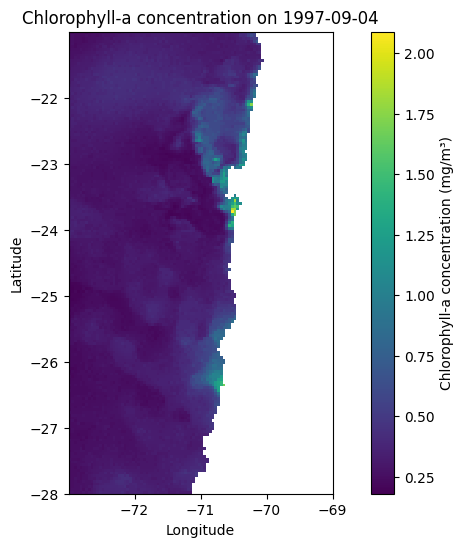

In [12]:
plot_chlorophyll(ds, 0)
plt.show()

It can be seen that there is a large region of missing data on the coast. Let's cut the maximum missing data region, to save RAM and computation time.

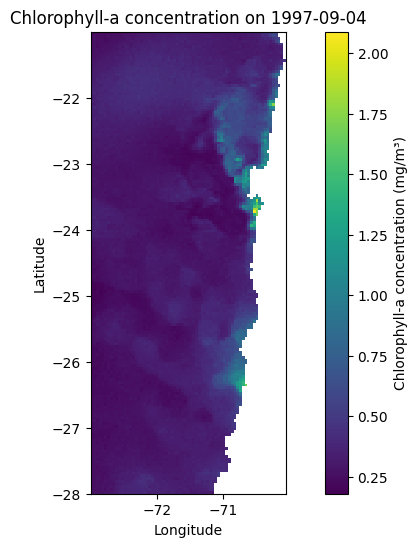

In [13]:
lon_max = ds.lon.where(~np.isnan(ds.CHL[0, :, :])).max()

ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

plot_chlorophyll(ds, 0)
plt.show()

Finally, the remaining null values must be kept as they are. They cannot be interpolated, as these data are from the coast, nor can they be replaced by some other value, as it may lead to erroneous conclusions in the future. It is best to create a mask for these values.

In [14]:
mask = ds.CHL[0, :, :].notnull()

In [17]:
print(ds)

<xarray.Dataset> Size: 470MB
Dimensions:  (lat: 168, lon: 71, time: 9842)
Coordinates:
  * lat      (lat) float32 672B -27.98 -27.94 -27.9 ... -21.1 -21.06 -21.02
  * lon      (lon) float32 284B -72.98 -72.94 -72.9 ... -70.15 -70.1 -70.06
  * time     (time) datetime64[ns] 79kB 1997-09-04 1997-09-05 ... 2024-08-14
Data variables:
    CHL      (time, lat, lon) float32 470MB 0.271 0.2744 0.2608 ... nan nan nan
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    ...                              ...
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-20T15:24:55Z
    title:                           

In [15]:
# ds = ds.resample(time="1D").mean(dim="time")

# Select a region around the coordinates (-23.627534, -70.396026)
# delta = 1
# lat, lon= -23.627534, -70.396026
# lon_min, lon_max = lon - delta, lon + delta
# lat_min, lat_max = lat - delta, lat + delta
# ds = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))